In [4]:
import numpy as np

from PIL import Image, ImageFilter
from matplotlib import pylab as pylab
from matplotlib import pyplot as plt

from scipy.signal.windows import kaiser_bessel_derived as kbd

from mdctn import mdct, imdct

# %matplotlib inline
pylab.rcParams['figure.figsize'] = (8, 8)

from pathlib import Path

image = 'earth-512'
experiment = 'blank'

output = Path('outputs') / image

output.mkdir(exist_ok=True, parents=True)

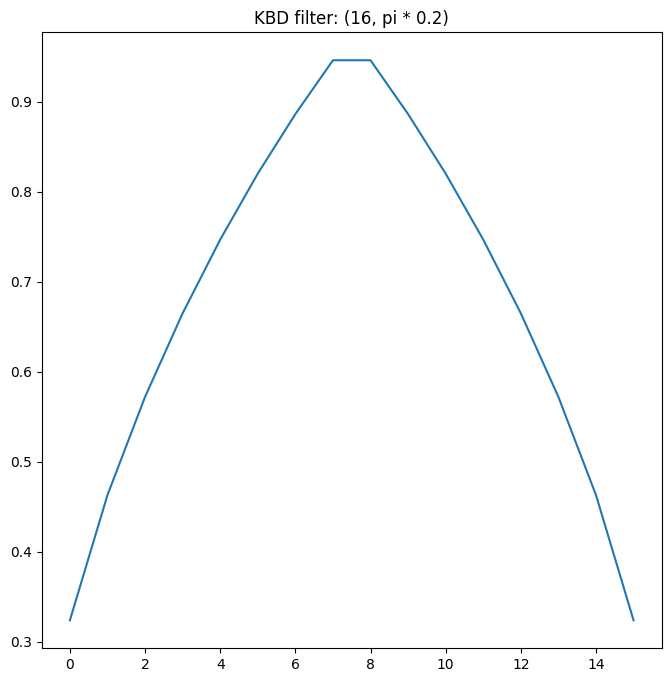

In [5]:
N=16

dct_type = 4
dct_norm = 'ortho'
kbd_alpha = 4.0
kbd_alpha = 0.2

wfltr = kbd(N, np.pi * kbd_alpha) # upto 709

plt.figure()
plt.plot(wfltr)
plt.title(f"KBD filter: (16, pi * {kbd_alpha})")

plt.savefig(f'{output}/kbd.png')

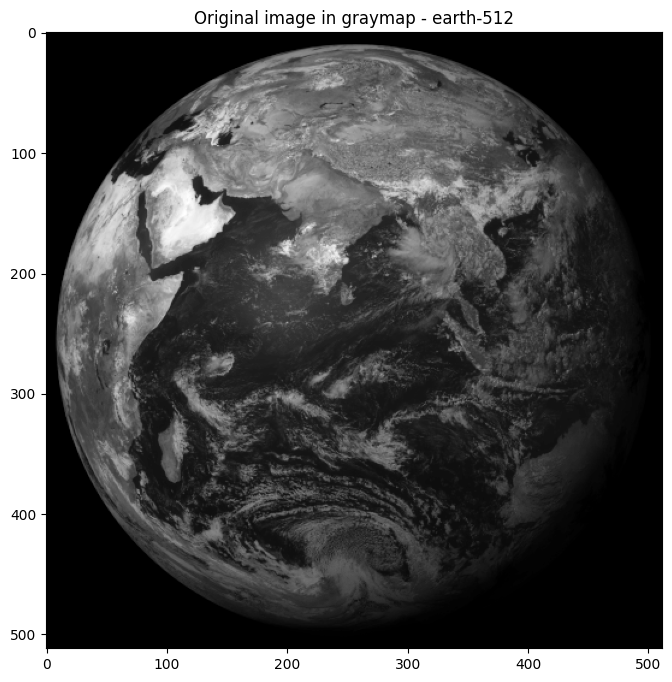

In [6]:
y, cb, cr = Image.open(f'../../images/{image}.png').convert('YCbCr').split()

im = np.array(y)
im = im[:im.shape[0] - im.shape[0]%8, :im.shape[1] - im.shape[1]%8]

im = im.astype(np.int64)

plt.figure()
plt.imshow(im, cmap='gray')
plt.title(f"Original image in graymap - {image}")

plt.imsave(f'{output}/original.png', im, cmap='gray')

In [7]:
quant_table_1 = np.ones(64)

quant_table_2 = [
    1,     1, 10000, 10000, 10000, 10000, 10000, 10000,
    1, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
]

quant_table_5 = [
    1,     1,     1,     1,     1, 10000, 10000, 10000,
    1,     1,     1,     1, 10000, 10000, 10000, 10000,
    1,     1,     1, 10000, 10000, 10000, 10000, 10000,
    1,     1, 10000, 10000, 10000, 10000, 10000, 10000,
    1, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
]

quant_table_11 = [
    1,     1,     1,     1,     1,     1,     1,     1,
    1,     1,     1,     1,     1,     1,     1,     1,
    1,     1,     1,     1,     1,     1,     1,     1,
    1,     1,     1,     1,     1,     1,     1,     1,
    1,     1,     1,     1,     1,     1,     1, 10000,
    1,     1,     1,     1,     1,     1, 10000, 10000,
    1,     1,     1,     1,     1, 10000, 10000, 10000,
    1,     1,     1,     1, 10000, 10000, 10000, 10000,
]

quant_table_5 = [
    1,     1,     1,     1,     1, 10000, 10000, 10000,
    1,     1,     1,     1, 10000, 10000, 10000, 10000,
    1,     1,     1, 10000, 10000, 10000, 10000, 10000,
    1,     1, 10000, 10000, 10000, 10000, 10000, 10000,
    1, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
10000, 10000, 10000, 10000, 10000, 10000, 10000,     1,
10000, 10000, 10000, 10000, 10000, 10000,     1, 10000,
10000, 10000, 10000, 10000, 10000,     1, 10000, 10000,
]

qtable = quant_table_5

In [8]:
def process(im, qtable):
    dct = np.zeros_like(im, dtype=np.float64)

    for i in range(im.shape[0]):
        dct[i] = mdct(im[i] - 128, N, wfltr, type=dct_type, norm=dct_norm, orthogonalize=True)

    for i in range(dct.shape[1]):
        dct[:, i] = mdct(dct[:, i], N, wfltr, type=dct_type, norm=dct_norm, orthogonalize=True)
    
    for i in np.r_[:dct.shape[0]:8]:
        for j in np.r_[:dct.shape[1]:8]:
            dct[i:(i+8), j:(j+8)] = (np.rint(dct[i:(i+8), j:(j+8)].ravel() / qtable) * qtable).reshape((8, 8))
        
    im_rec = np.zeros_like(im)

    for i in range(dct.shape[1]):
        dct[:, i] = imdct(dct[:, i], N, wfltr, type=dct_type, norm=dct_norm, orthogonalize=True)

    for i in range(im.shape[0]):
        im_rec[i] = imdct(dct[i], N, wfltr, type=dct_type, norm=dct_norm, orthogonalize=True)

    im_rec += 128

    return im_rec
    return im_rec.clip(0, 255).astype(np.uint8)

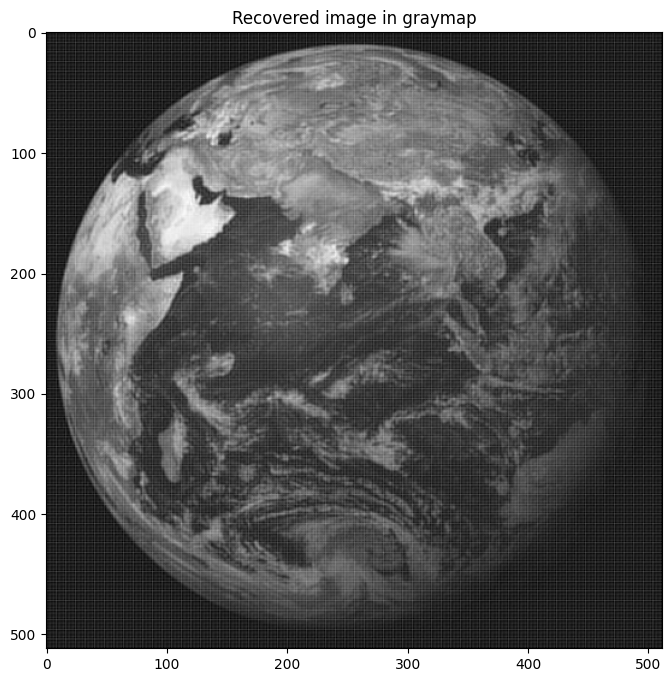

In [9]:
im_rec = process(im, qtable)

plt.figure()
plt.imshow(im_rec, cmap='gray')
plt.title("Recovered image in graymap")

plt.imsave(f'{output}/recovered.png', im_rec, cmap='gray')

In [10]:
im_rec[0:8, 0:8]

array([[ 30,  11,  16,  18,  13,  14,  18,   6],
       [ 11, -12,  -8,  -5, -11,  -9,  -4, -17],
       [ 16,  -8,  -1,   4,  -1,   1,   7,  -6],
       [ 18,  -5,   4,  10,   2,   4,  11,  -2],
       [ 13, -11,  -1,   2,  -8,  -6,   1, -11],
       [ 14,  -9,   1,   4,  -6,  -3,   5,  -8],
       [ 18,  -4,   7,  11,   1,   5,  14,  -1],
       [  6, -17,  -6,  -2, -11,  -8,  -1, -18]])